## QAOA Parameter Transfer: Graph A (Baseline)

### 1. Setup
- Imports
- Graph drawing function
- Helper utils

### 2. Graph A: MaxCut Formulation
- Create graph
- Show adjacency + plot

### 3. Convert to QUBO + Ising
- Use Qiskit Optimization

### 4. QAOA Ansatz
- Create and show circuit (with measurement)
- Create circuit (no measurement) for Estimator

### 5. QAOA Optimization
- Define cost function
- Run COBYLA
- Save trajectory

### 6. Results
- Print final energy + parameters
- Plot cost vs iteration
- Save outputs (JSON/PNG)



### Setup

In [2]:
%pip install qiskit==1.1.0 qiskit_optimization==0.6.1 matplotlib networkx pylatexenc --quiet

Note: you may need to restart the kernel to use updated packages.


In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import json
from pathlib import Path

from qiskit_optimization.applications import Maxcut
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit.primitives import Estimator
from qiskit.circuit.library import QAOAAnsatz
from scipy.optimize import minimize

%matplotlib inline

### Graph A - Build and Visualize

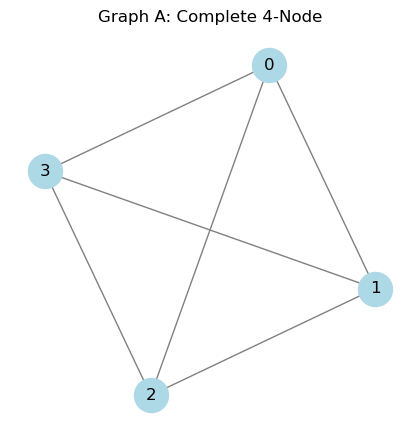

In [2]:
# Graph A: Complete 4-node
G = nx.complete_graph(4)
pos = nx.spring_layout(G, seed=42)

plt.figure(figsize=(4, 4))
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=600, edge_color='gray')
plt.title("Graph A: Complete 4-Node")
plt.show()


### Convert to QUBO

In [3]:
# Get adjacency matrix
w = nx.adjacency_matrix(G).todense()
maxcut = Maxcut(w)
qp = maxcut.to_quadratic_program()

# Convert to Ising Hamiltonian
qubit_op, offset = qp.to_ising()
print("Pauli-form Hamiltonian:\n", qubit_op)


Pauli-form Hamiltonian:
 SparsePauliOp(['IIZZ', 'IZIZ', 'ZIIZ', 'IZZI', 'ZIZI', 'ZZII'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j])


### QAOA

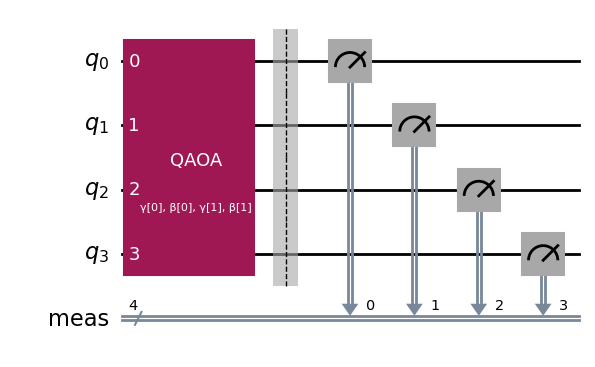

In [4]:
reps = 2
circuit = QAOAAnsatz(cost_operator=qubit_op, reps=reps)

# For display
circuit_with_measure = circuit.copy()
circuit_with_measure.measure_all()

# Draw
circuit_with_measure.draw('mpl')

### Define Estimator and Cost Function

In [5]:
estimator = Estimator()
objective_func_vals = []

def cost_func_estimator(params):
    job = estimator.run([circuit], [qubit_op], [params])
    result = job.result()
    cost = result.values[0]
    objective_func_vals.append(cost)
    return cost


### Optimization

In [6]:
# Initial guess for 2-rep QAOA: [γ1, β1, γ2, β2]
init_params = [np.pi, np.pi/2] * reps

result = minimize(
    cost_func_estimator,
    x0=init_params,
    method='COBYLA',
    tol=1e-2
)

print("Final cost:", result.fun)
print("Optimal parameters:", result.x)


Final cost: -0.9876202417905122
Optimal parameters: [3.98685856 2.08272959 2.34588922 2.40023421]


### Vizualize and Save